In [37]:
"""
Question 1: Are there any oddities that could cause someone problems when using the data to 
    answer questions? How would you deal with them?

Answer:
     - Oddity: First two rows of the raw data file include metadata
     - Solution: Delete and move data to metadata file
     
     - Oddity: Age column sort format is bad in Excel, may be interpreted as String
     - Solution: Use PySpark which can be used to infer column types
    
     - Oddity: Commas in "Geography" row data
     - Solution: Export as CSV puts these into double quotes, and PySpark infers with the read.csv() function
    
     - Oddity: White Space in "Geography code" column title
     - Solution: Handle using the header=True option in the PySpark
     
     - Oddity: Many Geography codes to a single geography 
     - Solution: Treat Geography code similar to a zip code. All questions refer to geography,
         therefore this column may be ignored
    
     - Oddity: Age column may contain "+"
     - Solution: Use PySpark regexp_replace to remove the "+", and create a new column of type Bool
            to hold the meaning of "+"
"""

'\nQuestion 1: Are there any oddities that could cause someone problems when using the data to \n    answer questions? How would you deal with them?\n\nAnswer:\n     - Oddity: First two rows of the raw data file include metadata\n     - Solution: Delete and move data to metadata file\n     \n     - Oddity: Age column sort format is bad in Excel, may be interpreted as String\n     - Solution: Use PySpark which can be used to infer column types\n    \n     - Oddity: Commas in "Geography" row data\n     - Solution: Export as CSV puts these into double quotes, and PySpark infers with the read.csv() function\n    \n     - Oddity: White Space in "Geography code" column title\n     - Solution: Handle using the header=True option in the PySpark\n     \n     - Oddity: Many Geography codes to a single geography \n     - Solution: Treat Geography code similar to a zip code. All questions refer to geography,\n         therefore this column may be ignored\n    \n     - Oddity: Age column may contai

In [40]:
"""
Description: Perform Schema-On-Read on raw data into a PySpark Dataframe, and prepare data for
    analytics queries.
"""

# I will use PySpark for quick and simple data transformations, and Seaborn for data visualizations
# You will need to download PySpark, Pandas, and Seaborn
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Window as W
from pyspark.sql.types import IntegerType as Int, BooleanType as Bool, StringType as Str
import seaborn as sns

# Create a spark object. You can visit the spark ui on localhost:4041 if 4040 is unavailable
spark = (SparkSession 
        .builder 
        .appName("Population Estimates") 
        .getOrCreate())

# Accept the raw data into a spark dataframe with option header=True
# Ignore records with no Geography and Geography Code, 
# Drop malformed rows with column types that do not confer to schema, and cache the dataframe for speed
raw_data_path = "Local-Data/population_estimates_rawdata.csv"
pop_df = (spark 
    .read 
    .option("header", "True") 
    .csv(raw_data_path, inferSchema=True, mode="DROPMALFORMED") 
    .dropna(how="any", subset=["Geography", "Geography code"]) 
    .cache())

# Clean the dataframe by preserving the meaning of + as a new boolean column age >= 90 using a UDF
above_90 = F.udf(lambda age: True if age >= 90 else False, Bool())

# After data is cleaned, proceed with analytics queries
cleaned_pop_df = (pop_df 
    .withColumn("Age", F.regexp_replace("Age", "\+", "").cast(Int())) 
    .withColumn("Above 90", above_90("Age")))

21/09/07 01:18:06 WARN CacheManager: Asked to cache already cached data.


In [41]:
"""
Question 2: Which geography contained the smallest total population in each year from 2013 to 2016?
"""

# Sum populations grouped by Geography for each year (using subquery on total_pop_by_geo table)
total_pop_by_geo = (cleaned_pop_df 
    .select("Geography", "2013", "2014", "2015", "2016") 
    .where("Sex in ('All')") 
    .groupBy("Geography") 
    .agg(F.sum("2013").alias("2013"), F.sum("2014").alias("2014"), F.sum("2015").alias("2015"), F.sum("2016").alias("2016")))

# 2013 Geography With Smallest Total Population
(total_pop_by_geo 
    .select("Geography", "2013")
    .withColumnRenamed("Geography", "Geography With Smallest Total Population")
    .where(F.col("2013") == total_pop_by_geo.select(F.min('2013')).head()[0]) 
    .show())

# 2014 Geography With Smallest Total Population
(total_pop_by_geo 
    .select("Geography", "2014") 
    .withColumnRenamed("Geography", "Geography With Smallest Total Population")
    .where(F.col("2014") == total_pop_by_geo.select(F.min('2014')).head()[0]) 
    .show())

# 2015 Geography With Smallest Total Population
(total_pop_by_geo 
    .select("Geography", "2015") 
    .withColumnRenamed("Geography", "Geography With Smallest Total Population")
    .where(F.col("2015") == total_pop_by_geo.select(F.min('2015')).head()[0]) 
    .show())

# 2016 Geography With Smallest Total Population
(total_pop_by_geo 
    .select("Geography", "2016") 
    .withColumnRenamed("Geography", "Geography With Smallest Total Population")
    .where(F.col("2016") == total_pop_by_geo.select(F.min('2016')).head()[0]) 
    .show())

+----------------------------------------+----+
|Geography With Smallest Total Population|2013|
+----------------------------------------+----+
|                         Isles of Scilly|2232|
+----------------------------------------+----+

+----------------------------------------+----+
|Geography With Smallest Total Population|2014|
+----------------------------------------+----+
|                         Isles of Scilly|2280|
+----------------------------------------+----+

+----------------------------------------+----+
|Geography With Smallest Total Population|2015|
+----------------------------------------+----+
|                         Isles of Scilly|2324|
+----------------------------------------+----+

+----------------------------------------+----+
|Geography With Smallest Total Population|2016|
+----------------------------------------+----+
|                         Isles of Scilly|2308|
+----------------------------------------+----+



In [42]:
"""
Question 3.1: Which geography had the highest female-to-male ratio in 2013, and what was the ratio?
"""

# Pivot Sex, and compute sum(Females) / sum(Males) for each geography in 2013
# Order descending and show the top value, which is the highest F-M ratio
(cleaned_pop_df 
    .select("Geography", "Sex", "2013") 
    .groupBy("Geography") 
    .pivot("Sex") 
    .sum() 
    .withColumn("Ratio", F.col("Female") / F.col("Male"))
    .withColumn("Highest", F.rank().over(W.orderBy(F.desc("Ratio"))))
    .select("Geography", "Ratio") 
    .where("Highest == 1")
    .withColumnRenamed("Geography", "Geography With The Highest Female-To-Male Ratio") 
    .show())

+-----------------------------------------------+-----------------+
|Geography With The Highest Female-To-Male Ratio|            Ratio|
+-----------------------------------------------+-----------------+
|                                       Knowsley|1.103591279555338|
+-----------------------------------------------+-----------------+



21/09/07 01:18:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [43]:
"""
Question 3.2: Comparing each geography's female-to-male ratio measurements in 2013 vs 2016, which 
    changed the most? Which changed the least?
"""

# Pivot Sex for 2013 and 2016, create columns with 2013 F-M Ratio, 2016 F-M Ratio, and the Delta
# Rank the Delta by Descending and Ascending to easily find the Ratios that changed the most and least
pop_ratio_delta_df = (cleaned_pop_df 
    .select("Geography", "Sex", "2013", "2016") 
    .groupBy("Geography") 
    .pivot("Sex") 
    .sum("2013", "2016") 
    .withColumn("2013 Ratio", F.col("Female_sum(2013)") / F.col("Male_sum(2013)")) 
    .withColumn("2016 Ratio", F.col("Female_sum(2016)") / F.col("Male_sum(2016)")) 
    .withColumn("2013 vs 2016 Delta", F.abs(F.col("2013 Ratio") - F.col("2016 Ratio")))
    .withColumn("Largest", F.rank().over(W.orderBy(F.desc("2013 vs 2016 Delta"))))
    .withColumn("Smallest", F.rank().over(W.orderBy(F.asc("2013 vs 2016 Delta")))))

# Most change would be largest ratio delta
(pop_ratio_delta_df 
    .select("Geography", "2013 vs 2016 Delta") 
    .where("Largest == 1")
    .withColumnRenamed("Geography", "Geography That Changed The Most") 
    .show())

# Least change would be lowest ratio delta
(pop_ratio_delta_df 
    .select("Geography", "2013 vs 2016 Delta")
    .where("Smallest == 1")
    .withColumnRenamed("Geography", "Geography That Changed The Least") 
    .show())


21/09/07 01:18:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-------------------------------+------------------+
|Geography That Changed The Most|2013 vs 2016 Delta|
+-------------------------------+------------------+
|                          Moray|0.0674442377540787|
+-------------------------------+------------------+



21/09/07 01:18:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+--------------------------------+-------------------+
|Geography That Changed The Least| 2013 vs 2016 Delta|
+--------------------------------+-------------------+
|                      Winchester|3.11390344611695E-5|
+--------------------------------+-------------------+



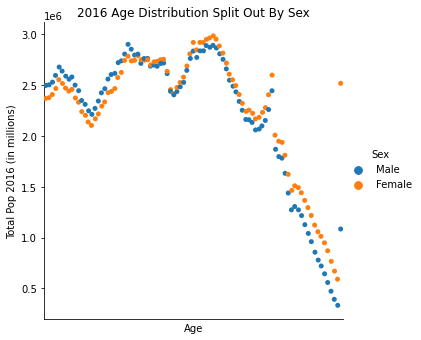

In [73]:
"""
Description: Plot a visualization of the 2016 age distribution split out by sex. This may take
    several seconds to produce the chart.
"""

# First, we calculate the distribution by Sex and Age in 2016, and convert to a pandas dataframe
age_dist_2016_pandas_df = (cleaned_pop_df 
    .select("Age", "Sex", "2016") 
    .where("Sex in ('Male', 'Female')") 
    .groupBy("Age", "Sex") 
    .agg(F.sum("2016").alias("Total Pop 2016 (in millions)")))

# Second, I use seaborn to perform catplot to 'split-out' Male dist and Female dist
(sns.catplot(data=age_dist_2016_pandas_df.toPandas(), x='Age', y='Total Pop 2016 (in millions)', hue='Sex')
    .set(title='2016 Age Distribution Split Out By Sex', xticklabels=[], xticks=[]))


In [ ]:
"""
Question 4.1: What are the anomalies? Describe the factors that could account for anomalies.

Answer:
    - Anomaly 1: 90 year olds 
    - Factors: This is because we are lumping all 90+ into one Age bin

    - Anomaly 2: Massive spike in population Age around 75 during a steady decline in population in this Age range
    - Factors: Older people who want to retire probably go to these places because they are peaceful

    - Anomaly 3: Dips in teen and mid-life years
    - Factors: People leave these areas to travel other parts of the world
"""

In [46]:
"""
Description: Geographies which have a "particularly high or low" proportion of 
    over-65s between 2013-2016. Calculates a summary dataframe for 2013 and 2016 which contains
    the means and stddev used to find particularly high and low proportions of over 65s
"""

# To be aggregated when total pop is aggregated
above_65 = F.udf(lambda age, pop: pop if age > 65 else 0, Int())

# Displays positive or negative change between proportions
direction = F.udf(lambda prop_2016, prop_2013: "+" if prop_2016 - prop_2013 >= 0 else "-", Str())

# Calculate the Proportion of Age > 65 for 2013 vs 2016, and direction for Positive and Negative change
pop_statistics_df = (cleaned_pop_df 
    .select("Geography", "Age", "2013", "2016") 
    .where("Sex in ('All')")
    .withColumn("Older Pop 2013", above_65("Age", "2013"))
    .withColumn("Older Pop 2016", above_65("Age", "2016"))
    .groupBy("Geography") 
    .agg(F.sum("2013"), F.sum("Older Pop 2013"),
         F.sum("2016"), F.sum("Older Pop 2016"))
    .withColumn("Proportion > 65: 2013", F.col("sum(Older Pop 2013)") / F.col("sum(2013)"))
    .withColumn("Proportion > 65: 2016", F.col("sum(Older Pop 2016)") / F.col("sum(2016)"))
    .withColumn("2013 vs 2016", F.abs(F.col("Proportion > 65: 2016") - F.col("Proportion > 65: 2013")))
    .withColumn("Direction", direction("Proportion > 65: 2016", "Proportion > 65: 2013")))

# I calculate the mean and stddev of the Proportion > 65: 2013
# I create new columns with "particularly low" and "particularly high" values using two stddevs left and right
summary_2013 = (pop_statistics_df
    .select(F.mean("Proportion > 65: 2013").alias("mean"), F.stddev("Proportion > 65: 2013").alias("stddev"))
    .withColumn("Two Deviations Right", F.col("mean") + (F.col("stddev") * 2))
    .withColumn("Two Deviations Left", F.col("mean") - (F.col("stddev") * 2)))

# Geographys with particularly low proportion of over-65's (2 standard deviations left)
(pop_statistics_df
    .select("Geography", "Proportion > 65: 2013")
    .where(F.col("Proportion > 65: 2013") < summary_2013.select("Two Deviations Left").head()[0])
    .withColumnRenamed("Geography", "Geography with Particularly Low Proportion")
    .orderBy(F.desc("Proportion > 65: 2013"))
    .show())

# Geographys with particularly high proportion of over-65's (2 standard deviations right)
(pop_statistics_df
    .select("Geography", "Proportion > 65: 2013")
    .where(F.col("Proportion > 65: 2013") > summary_2013.select("Two Deviations Right").head()[0])
    .withColumnRenamed("Geography", "Geography with Particularly High Proportion")
    .orderBy(F.desc("Proportion > 65: 2013"))
    .show())

# Repeat for 2016
summary_2016 = (pop_statistics_df
    .select(F.mean("Proportion > 65: 2016").alias("mean"), F.stddev("Proportion > 65: 2016").alias("stddev"))
    .withColumn("Two Deviations Right", F.col("mean") + (F.col("stddev") * 2))
    .withColumn("Two Deviations Left", F.col("mean") - (F.col("stddev") * 2)))

(pop_statistics_df
    .select("Geography", "Proportion > 65: 2016")
    .where(F.col("Proportion > 65: 2016") < summary_2016.select("Two Deviations Left").head()[0])
    .withColumnRenamed("Geography", "Geography with Particularly Low Proportion")
    .orderBy(F.desc("Proportion > 65: 2016"))
    .show())

(pop_statistics_df
    .select("Geography", "Proportion > 65: 2016")
    .where(F.col("Proportion > 65: 2016") > summary_2016.select("Two Deviations Right").head()[0])
    .withColumnRenamed("Geography", "Geography with Particularly High Proportion")
    .orderBy(F.desc("Proportion > 65: 2016"))
    .show())

+------------------------------------------+---------------------+
|Geography with Particularly Low Proportion|Proportion > 65: 2013|
+------------------------------------------+---------------------+
|                            Waltham Forest|  0.09453078853410686|
|                      Barking and Dagenham|   0.0943442825388985|
|                      Hammersmith and F...|  0.09062316366790721|
|                                Manchester|  0.08836410927321608|
|                                  Lewisham|  0.08807044517436578|
|                                    Slough|   0.0866358093746504|
|                                Wandsworth|  0.08472993340117739|
|                                  Haringey|  0.08380855474474726|
|                                 Islington|  0.08198135122478219|
|                                 Southwark|  0.07302698808905567|
|                                   Lambeth|  0.07178543924745896|
|                                   Hackney|  0.06610484926897

In [64]:
"""
Description: Geographies which show the "largest" change in proportion of 
    over-65s between 2013 and 2016. Calculates a summary dataframe for 2013 vs 2016 which contains
    the means and stddev used to find the largest positive and largest negative changes.
"""

# I calculate the mean and stddev of the 2013 vs 2016 Proportion > 65
# I create a new column with "large" values two stddev to the right
summary_increasing = (pop_statistics_df
    .where(F.col("Direction") == "+")
    .select(F.mean("2013 vs 2016").alias("mean"), F.stddev("2013 vs 2016").alias("stddev"))
    .withColumn("Two Deviations Right", F.col("mean") + (F.col("stddev") * 2)))

# Largest Increasing (Direction = '+') Proportion 2013 vs 2016 (more older people)
(pop_statistics_df
    .select("Geography", "2013 vs 2016")
    .where((F.col("Direction") == "+") & (F.col("2013 vs 2016") > summary_increasing.select("Two Deviations Right").head()[0]))
    .orderBy(F.desc("2013 vs 2016"))
    .withColumnRenamed("2013 vs 2016", "Increasing Proportion of Age > 65: 2013 vs 2016")
    .show())

# Same as above, except Direction = "-" (less older people)
summary_decreasing = (pop_statistics_df
    .where(F.col("Direction") == "-")
    .select(F.mean("2013 vs 2016").alias("mean"), F.stddev("2013 vs 2016").alias("stddev"))
    .withColumn("Two Deviations Right", F.col("mean") + (F.col("stddev") * 2)))

(pop_statistics_df
    .select("Geography", "2013 vs 2016")
    .where((F.col("Direction") == "-") & (F.col("2013 vs 2016") > summary_decreasing.select("Two Deviations Right").head()[0]))
    .orderBy(F.desc("2013 vs 2016"))
    .withColumnRenamed("2013 vs 2016", "Decreasing Proportion of Age > 65: 2013 vs 2016")
    .show())

+--------------------+-----------------------------------------------+
|           Geography|Increasing Proportion of Age > 65: 2013 vs 2016|
+--------------------+-----------------------------------------------+
|Dumfries and Gall...|                            0.07208544091035043|
|            Highland|                            0.06962852077652606|
|       Monmouthshire|                            0.05305590272924127|
|         Eilean Siar|                            0.05064590881083439|
|   Rhondda Cynon Taf|                           0.050216794547647436|
|   East Renfrewshire|                           0.046645669795442296|
|               Powys|                           0.038463061258291215|
| East Dunbartonshire|                           0.030429908776102188|
|       Pembrokeshire|                            0.03036034444663252|
|               Moray|                           0.027707438515945565|
+--------------------+-----------------------------------------------+

+----

In [52]:
"""
Question 4.2: Are your numerical results realistic? What factors could explain the outliers?

Answer:
    Part 1 - Particularly high or low proportion of over-65s between 2013-2016
    
        Yes, because there are more increasing than decreasing. I believe my numerical results are realistic. 
        This is because densely populated cities such as Cambridge or City of London
        are not changing in proportion as much as much smaller cities.
        
    Part 2 - Largest change in proportion of over 65s between 2013 and 2016.
        
        Yes,
    
"""

'\nDescription: Are your numerical results realistic? What factors could explain the outliers?\nAnswer:\n    Yes, because there are more increasing than decreasing. I believe my numerical results are realistic. \n    This is because densely populated cities such as Cambridge or City of London\n    are not changing in proportion as much as much smaller cities.\n'